### Library Import

In [23]:
import sys
sys.path.append('../')
import importlib


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.preprocessing import Normalizer

from sklearn.manifold import TSNE
import umap
import os

import sys
sys.path.append('../ltnc')

from ltnc import ltnc
import metrics as mts
importlib.reload(ltnc)
importlib.reload(mts)

## turn off warning
import warnings
warnings.filterwarnings("ignore")

dr_measures = [
	"lc_dsc", "ls_dsc",
	"lc_btw_ch", "ls_btw_ch",   
	"trust", "conti", 
    "mrre_lh", "mrre_hl", 
	"stead", "cohev", 
	"kl_div", "dtm", 
  "s_trust", "s_conti"  ,
  "dsc", "sil",
]
dr_measures_name = [
	"Label-Trustworthiness [DSC]", "Label-Continuity [DSC]",
	"Label-Trustworthiness [CH$_{btwn}$]", "Label-Continuity [CH$_{btwn}$]", 
	"Trustworthiness", "Continuity",
      "MRRE [False]", "MRRE [Missing]", 
	"Steadiness", "Cohesiveness", 
		"1 - KL-Divergence", "1 - DTM", 
  "CA-Trustworthiness", "CA-Continuity",

  "1 - DSC", "Silhouette",
]

dr_measures_line_width = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
linestyle_list = [
	"solid", "dashed", "solid", "dashed", 
	"solid", "dashed", "solid", "dashed", "solid", "dashed", 
	(5, (10, 3)), (5, (10, 3)), "solid", "dashed", (5, (10, 3)), (5, (10, 3))
]
tab10 = sns.color_palette("tab10")
color_list = [
	tab10[0], tab10[0], tab10[1], tab10[1],
	tab10[2], tab10[2], tab10[3], tab10[3], tab10[4], tab10[4],
	tab10[5], tab10[6], tab10[7], tab10[7], tab10[8], tab10[9]
]

k_cand = [5, 10, 15, 20, 25]
sigma_cand = [0.01, 0.1, 1]

## Run the function definitions

In [15]:
def run_all_metrics(raw, emb, labels, k_cand, sigma_cand):
	"""
	compute all metrics
	"""
	final_results = {}

	## LS & LC (DSC)
	lsnc_obj = ltnc.LabelTNC(raw, emb, labels, cvm="dsc")
	results = lsnc_obj.run()
	final_results["ls_dsc"] = results["lc"]
	final_results["lc_dsc"] = results["lt"]

	## LS & LC (CH_btwn)
	lsnc_obj = ltnc.LabelTNC(raw, emb, labels, cvm="btw_ch")
	results = lsnc_obj.run()
	final_results["ls_btw_ch"] = results["lc"]
	final_results["lc_btw_ch"] = results["lt"]

	## Steadiness & Cohesiveness
	results = mts.stead_cohev(raw, emb)
	final_results["stead"] = results["stead"]
	final_results["cohev"] = results["cohev"]

	## Silhouette / DSC
	final_results["sil"] = mts.silhouette(emb, labels)
	final_results["dsc"] = 1 - mts.dsc(emb, labels)

	## Trust / Conti / MRRE
	trust, conti, mrre_hl, mrre_lh = 0, 0, 0, 0
	for k in k_cand:
		results = mts.trust_conti_mrre(raw, emb, k = k)
		trust += results["trust"]
		conti += results["conti"]
		mrre_hl += results["mrre_hl"]
		mrre_lh += results["mrre_lh"]
	final_results["trust"] = trust / len(k_cand)
	final_results["conti"] = conti / len(k_cand)
	final_results["mrre_hl"] = mrre_hl / len(k_cand)
	final_results["mrre_lh"] = mrre_lh / len(k_cand)

	## superviesed Trust / Conti
	s_trust, s_conti = 0, 0
	for k in k_cand:
		results = mts.supervised_trust_conti(raw, emb, labels, k = k)
		s_trust += results["s_trust"]
		s_conti += results["s_conti"]
	final_results["s_trust"] = s_trust / len(k_cand)
	final_results["s_conti"] = s_conti / len(k_cand)

	## KL / DTM
	kl_div, dtm = 0, 0, 
	for sigma in sigma_cand:
		results = mts.kl_div_rmse_dtm(raw, emb, sigma = sigma)
		kl_div += results["kl_div"]
		dtm += results["dtm"]
	final_results["kl_div"] = 1 - kl_div / len(sigma_cand)
	final_results["dtm"] = 1 - dtm / len(sigma_cand)

	return final_results	

In [54]:
## function to plot the results using seabron (line chart)
def lineplot_results(results_list_dict, title, index_range, x_list, ax=None, invert_x_axis=False,  y_label=None, x_label=None, bbox_to_anchor=None, xticklabels=None):


	plt_inst = ax if ax is not None else plt
	sns.set_style("whitegrid")

	if (ax is None):
		plt_inst.figure(figsize=(4, 4))
	for idx in range(index_range[0], index_range[1]):
		plt_inst.plot(
			x_list, results_list_dict[dr_measures[idx]], 
			label = dr_measures_name[idx], linestyle=linestyle_list[idx], color=color_list[idx], linewidth=1.3
		)

	if (invert_x_axis):
		if ax is None:
			plt_inst.gca().invert_xaxis()
		else:
			ax.invert_xaxis()

	if (y_label != None):
		plt_inst.set_ylabel(y_label)
	if (x_label != None):
		plt_inst.set_xlabel(x_label)
	
	if (xticklabels == "int"):
		## make xticks as integer
		# plt_inst.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
		## set interval as 2
		plt_inst.xaxis.set_major_locator(ticker.MultipleLocator(2))

	## save fig with high resolution
	if (ax is None):
		## show legend outside the plot

		plt_inst.tight_layout()
		plt_inst.savefig(f"./plot/{title}.png", dpi=300)

		plt_inst.show()

def add_legend(ax=None, bbox_to_anchor=None):
	## center legend
	if (ax is None):
		plt.legend(bbox_to_anchor=(0.5, 1.05) if bbox_to_anchor is None else bbox_to_anchor, ncol=7)
	else:
		ax.legend(bbox_to_anchor=(0.5, 1.05) if bbox_to_anchor is None else bbox_to_anchor, ncol=7)

In [4]:
def compute_metrics(raws, embs, labels, list_num, path):
	results_list_dict = {}
	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = [] 

	for i in tqdm(range(list_num)):
		## if the type of raw is list,
		if isinstance(raws, list):
			raw = raws[i]
			emb = embs
		else:
			raw = raws
			emb = embs[i]

		final_results = run_all_metrics(raw, emb, labels, k_cand, sigma_cand)
		for dr_measure in dr_measures:
			results_list_dict[dr_measure].append(final_results[dr_measure])

	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = np.array(results_list_dict[dr_measure])

	## Save the results
	for dr_measure in dr_measures:
		## if the path does not exists, make it
		if not os.path.exists(f"./results/{path}"):
			os.makedirs(f"./results/{path}")
		np.save(f"./results/{path}/{dr_measure}.npy", np.array(results_list_dict[dr_measure]))
	
	return results_list_dict

In [5]:
def read_results(path):
	results_list_dict = {}
	for dr_measure in dr_measures:
		results_list_dict[dr_measure] = np.load(f"./results/{path}/{dr_measure}.npy")
	return results_list_dict

In [6]:
def visualize_results(embs, labels, index=[0, 4, 8, 12, 15, 20, 24], s=1, path=None, ylen=3, invert=False):
	"""
	visualize the embeddings
	"""
	## plot the embeddings
	fig, ax = plt.subplots(1, len(index), figsize=(len(index) * 3, ylen), sharex=True, sharey=True)

	
	for i, sidx in enumerate(index):
		if invert:
			sidx = len(embs) - sidx - 1
		ax[i].scatter(embs[sidx][ :, 0], embs[sidx][ :, 1], c=labels, cmap='tab10', s=s)
		ax[i].axis('off')
	plt.tight_layout()

	if path is not None:
		plt.savefig(f"{path}.png", dpi=300)
		plt.savefig(f"{path}.pdf", dpi=300)

	plt.show()

## Experiments

### Experiment A (Randomlizing projection)
##### The purpose of this experiment is to check whether Label-SnC well captures obvious distortions 

In [7]:
raw, labels = np.load("./labeled-datasets/npy/coil20/data.npy"), np.load("./labeled-datasets/npy/coil20/label.npy")
emb_skeleton = umap.UMAP().fit_transform(raw)
## normalize emb_skeleton column by column
# emb_skeleton[:, 0] = (emb_skeleton[:, 0] - np.min(emb_skeleton[:, 0])) / (np.max(emb_skeleton[:, 0]) - np.min(emb_skeleton[:, 0]))
# emb_skeleton[:, 1] = (emb_skeleton[:, 1] - np.min(emb_skeleton[:, 1])) / (np.max(emb_skeleton[:, 1]) - np.min(emb_skeleton[:, 1]))
## make random project
emb_random = np.random.rand(emb_skeleton.shape[0], emb_skeleton.shape[1])
emb_random[:, 0] = emb_random[:, 0] * (np.max(emb_skeleton[:, 0]) - np.min(emb_skeleton[:, 0])) + np.min(emb_skeleton[:, 0])
emb_random[:, 1] = emb_random[:, 1] * (np.max(emb_skeleton[:, 1]) - np.min(emb_skeleton[:, 1])) + np.min(emb_skeleton[:, 1])

embs = []
## randomize emb_skeleton in varying magnitude (25 levels) and add it to embs
for i in range(25):
	random_rate = i / 25
	random_bool_arr = np.random.rand(emb_skeleton.shape[0], emb_skeleton.shape[1]) > random_rate
	random_bool_arr = random_bool_arr.astype(int)
	emb = emb_skeleton * random_bool_arr + emb_random * (1 - random_bool_arr)
	embs.append(emb)

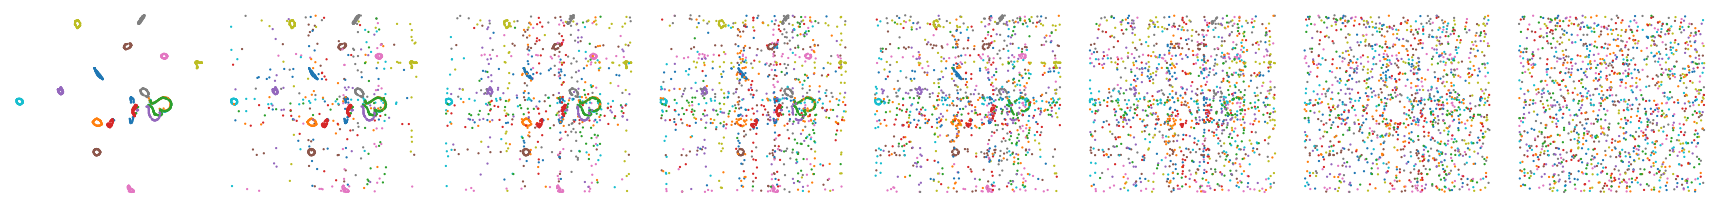

In [8]:
visualize_results(embs, labels, index=[0, 3, 6, 9, 12, 16, 20, 24], s=1.5, path="./plot_embeddings/A")

In [16]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "randomizing_emb")

100%|██████████| 25/25 [05:17<00:00, 12.71s/it]


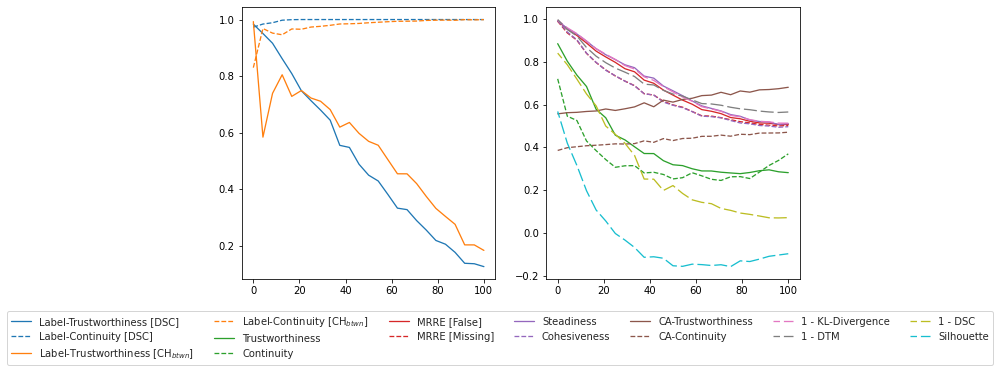

In [17]:
results_list_dict = read_results("randomizing_emb")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
lineplot_results(results_list_dict, "randomizing_emb", index_range=(0, 4), x_list = np.linspace(0, 100, 25), ax=axs[0])
lineplot_results(results_list_dict, "randomizing_emb", index_range=(4, 16), x_list = np.linspace(0, 100, 25), ax=axs[1])
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))


## Experiment B - about compression distortion

### Experiment B-1 (6 hyperspheres and overlapping classes)

In [12]:
raw, labels = np.load("./spheres_data/data/raw.npy"), np.load("./spheres_data/data/label.npy")
embs = []
for i in range(25):
	embs.append(np.load(f"./spheres_data/data/overlapping/circle_{i}.npy"))

In [13]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "overlapping_circles")

100%|██████████| 25/25 [12:05<00:00, 29.01s/it]


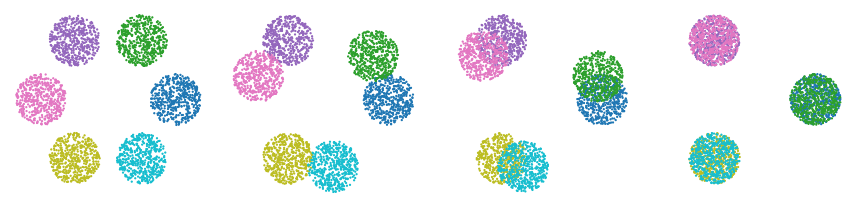

In [52]:
visualize_results(embs, labels, index=[0, 8, 16, 24], s=1.5, path="./plot_embeddings/B-1-1")

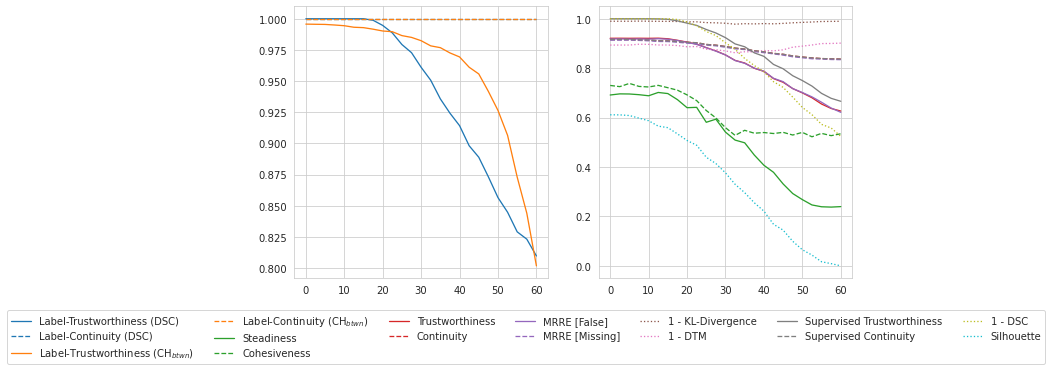

In [15]:

results_list_dict = read_results("overlapping_circles")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
lineplot_results(results_list_dict, "overlapping_circles", index_range=(0, 4), x_list = np.linspace(0, 60, 25), ax=axs[0])
lineplot_results(results_list_dict, "overlapping_circles", index_range=(4, 16), x_list = np.linspace(0, 60, 25), ax=axs[1])
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))

### Experiment B-2 (6 hyperspheres and overlapping classes - round2)

In [16]:
raw, labels = np.load("./spheres_data/data/raw.npy"), np.load("./spheres_data/data/label.npy")
embs = []
for i in range(25):
	embs.append(np.load(f"./spheres_data/data/overlapping_more/circle_{i}.npy"))

In [17]:
results_list_dict = compute_metrics(raw, embs, labels, 25, "overlapping_circles_more")

100%|██████████| 25/25 [11:40<00:00, 28.03s/it]


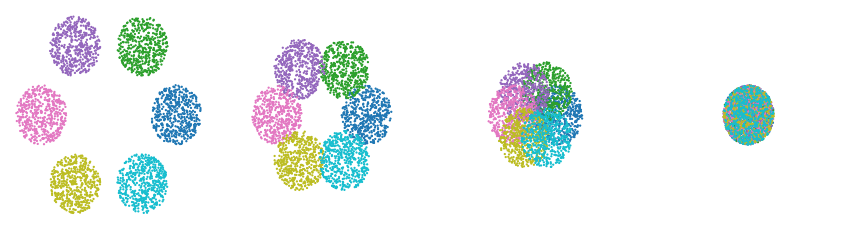

In [18]:
visualize_results(embs, labels, index=[0, 8, 16, 24], s=1.5, path="./plot_embeddings/B-1-2", ylen=3.3)

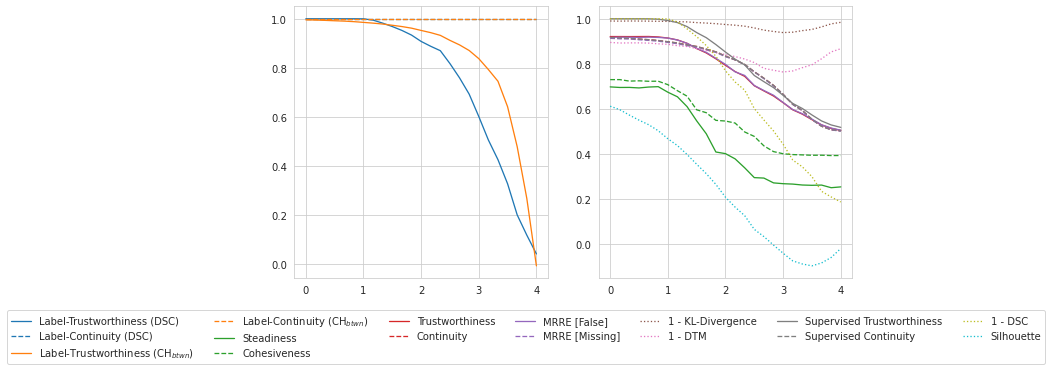

In [20]:


results_list_dict = read_results("overlapping_circles_more")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
lineplot_results(results_list_dict, "overlapping_circles_more", index_range=(0, 4), x_list = np.linspace(0, 4, 25), ax=axs[0])
lineplot_results(results_list_dict, "overlapping_circles_more", index_range=(4, 16), x_list = np.linspace(0, 4, 25), ax=axs[1])
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))

### Experiment C (PCA Expansion test)

#### Currently with fashion-mnist dataset

In [27]:
## Dataset Generation
raw, labels = np.load("./labeled-datasets/npy/fashion_mnist/data.npy"), np.load("./labeled-datasets/npy/fashion_mnist/label.npy")
range_limit = 10
emb_pca = PCA(n_components=range_limit + 5).fit_transform(raw)
ex_var = PCA(n_components=range_limit + 5).fit(raw).explained_variance_ratio_
embs = []
explained_variances = []
for i in range(range_limit):
	embs.append(emb_pca[:, :i + 1])
	explained_variances.append(ex_var[:i + 1].sum())


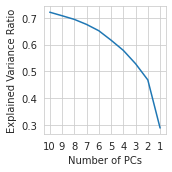

In [28]:
sns.set_style("whitegrid")

## set size
fig, ax = plt.subplots(figsize=(2.5, 2.5))

sns.lineplot(x=np.arange(1, range_limit + 1)[::-1], y=explained_variances[::-1])
## reverse x axis
ax.invert_xaxis()
## set x axis label
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Explained Variance Ratio")
## set x ticks as integers
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig("./explained_variance/ex_exp_C.png", dpi=300)
plt.savefig("./explained_variance/ex_exp_C.pdf", dpi=300)


In [22]:
## Compute metrics
results_list_dict = compute_metrics(raw, embs, labels, range_limit, "pca_expansion_digits")


100%|██████████| 10/10 [06:04<00:00, 36.40s/it]


In [100]:
embs_umap = []
index_list = [0, 1, 2, 3, 4, 6, 8, 9]
for idx, i in enumerate(index_list):
	if i == 0:
		embs_umap.append(np.concatenate([embs[i], embs[i]], axis=1))
	elif i == 1:
		embs_umap.append(embs[i])
	else:
		embs_umap.append(umap.UMAP(random_state=0, init=embs_umap[idx-1]).fit_transform(embs[i]))

for i, emb_umap in enumerate(embs_umap):
	x_max, x_min = np.max(emb_umap[:, 0]), np.min(emb_umap[:, 0])
	y_max, y_min = np.max(emb_umap[:, 1]), np.min(emb_umap[:, 1])
	emb_umap[:, 0] = (emb_umap[:, 0] - x_min) / (x_max - x_min)
	emb_umap[:, 1] = (emb_umap[:, 1] - y_min) / (y_max - y_min)



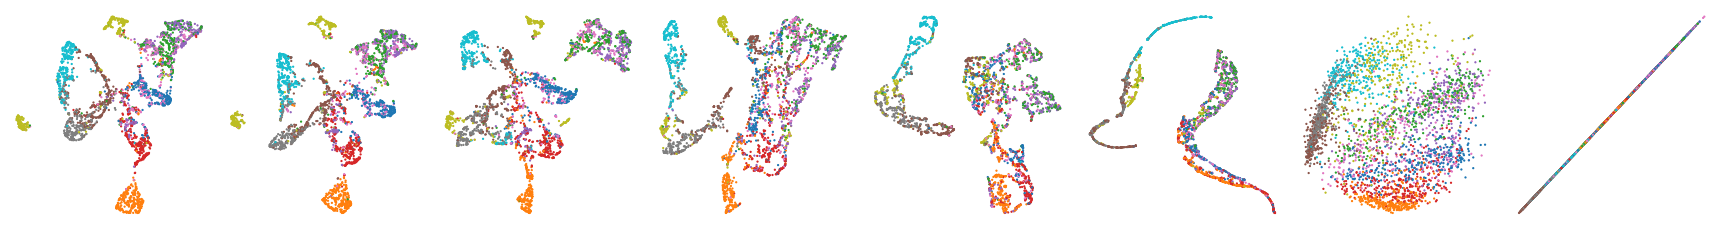

In [103]:
visualize_results(embs_umap, labels, index=range(len(index_list)), s=1.5, path="./plot_embeddings/C", ylen=3.3, invert=True)

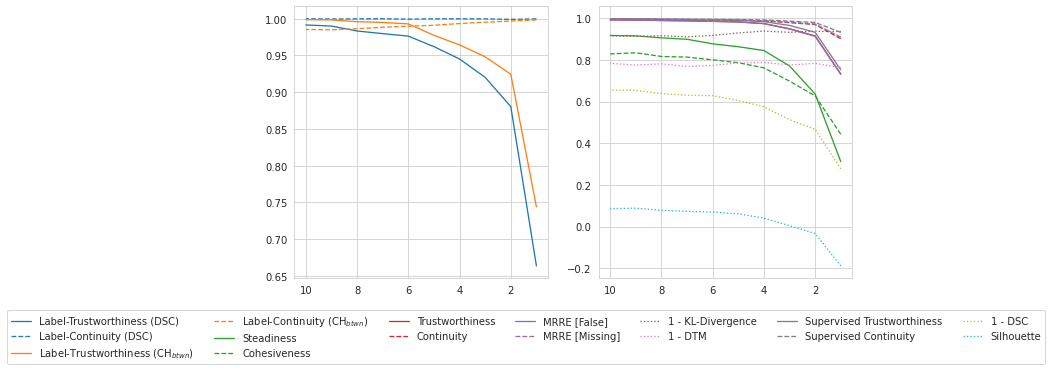

In [23]:


results_list_dict = read_results("pca_expansion_digits")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
lineplot_results(results_list_dict, "pca_expansion_digits", index_range=(0, 4), x_list = range(1, 11), ax=axs[0], invert_x_axis=True)
lineplot_results(results_list_dict, "pca_expansion_digits", index_range=(4, 16), x_list = range(1, 11), ax=axs[1], invert_x_axis=True)
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))

### Experiment D (Randomizing data)

In [18]:
raw, labels = np.load("./labeled-datasets/npy/coil20/data.npy"), np.load("./labeled-datasets/npy/coil20/label.npy")
emb = umap.UMAP().fit_transform(raw)

raw_skeleton = raw.copy()
## normalize raw_skeleton
# raw_skeleton = (raw_skeleton - np.min(raw_skeleton, axis=0)) / (np.max(raw_skeleton, axis=0) - np.min(raw_skeleton, axis=0))
raw_random = np.random.rand(raw_skeleton.shape[0], raw_skeleton.shape[1])
for i in range(raw_skeleton.shape[1]):
	raw_random[:, i] = raw_random[:, i] * (np.max(raw_skeleton[:, i]) - np.min(raw_skeleton[:, i])) + np.min(raw_skeleton[:, i])
 
raws = []
## randomize emb_skeleton in varying magnitude (25 levels) and add it to embs
for i in range(25):
	random_rate = i / 25
	random_bool_arr = np.random.rand(raw_skeleton.shape[0], raw_skeleton.shape[1]) > random_rate
	random_bool_arr = random_bool_arr.astype(int)
	raw_curr = raw_skeleton * random_bool_arr + raw_random * (1 - random_bool_arr)
	raws.append(raw_curr)

In [ ]:
raws_umap = []
index_list = [0, 4, 6, 8, 10, 12, 14, 24]
for idx, i in enumerate(index_list):
	if idx == 0:
		raws_umap.append(umap.UMAP(random_state=0).fit_transform(raws[i]))
	else:
		raws_umap.append(umap.UMAP(random_state=0, init=raws_umap[idx-1]).fit_transform(raws[i]))

for i, raw_umap in enumerate(raws_umap):
	x_max, x_min = np.max(raw_umap[:, 0]), np.min(raw_umap[:, 0])
	y_max, y_min = np.max(raw_umap[:, 1]), np.min(raw_umap[:, 1])
	raw_umap[:, 0] = (raw_umap[:, 0] - x_min) / (x_max - x_min)
	raw_umap[:, 1] = (raw_umap[:, 1] - y_min) / (y_max - y_min)


visualize_results(raws_umap, labels, index=range(len(index_list)), s=1.5, path="./plot_embeddings/D", ylen=3.3)

In [20]:
results_list_dict = compute_metrics(raws, emb, labels, 25, "mixing_raw")

100%|██████████| 25/25 [07:00<00:00, 16.84s/it]


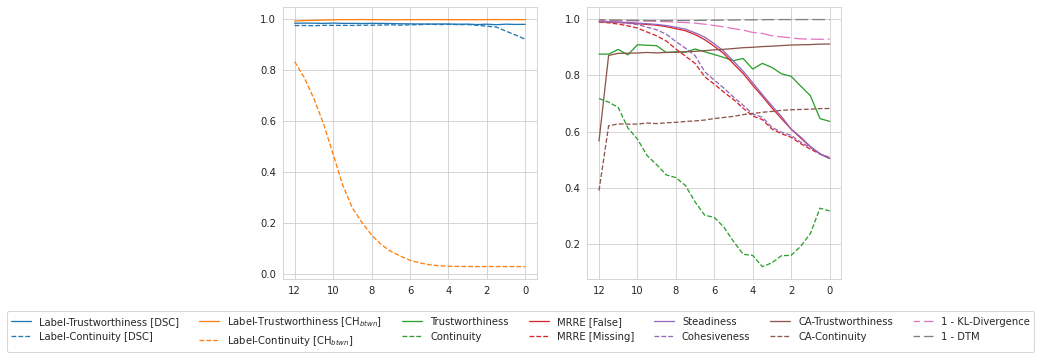

In [21]:

results_list_dict = read_results("mixing_raw")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
lineplot_results(results_list_dict, "mixing_raw", index_range=(0, 4), x_list = np.linspace(12, 0, 25), ax=axs[0], invert_x_axis=True)
lineplot_results(results_list_dict, "mixing_raw", index_range=(4, 14), x_list = np.linspace(12, 0, 25), ax=axs[1], invert_x_axis=True)
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))


### Experiment D (6 circles and overlapping hd spheres)

In [29]:
emb, labels = np.load("./spheres_data/data/overlapping_raw/emb.npy"), np.load("./spheres_data/data/overlapping_raw/label.npy")
raws = []
for i in range(25):
	raws.append(np.load(f"./spheres_data/data/overlapping_raw/raw_{i}.npy"))

In [30]:
results_list_dict = compute_metrics(raws, emb, labels, 25, "overlapping_raw")

100%|██████████| 25/25 [16:25<00:00, 39.43s/it]


In [31]:
raws_umap = []
index_list = [0, 7, 13, 19, 20, 21, 22, 24]
for idx, i in enumerate(index_list):
	if idx == 0:
		raws_umap.append(umap.UMAP(random_state=0).fit_transform(raws[i]))
	else:
		raws_umap.append(umap.UMAP(random_state=0, init=raws_umap[idx-1]).fit_transform(raws[i]))

for i, raw_umap in enumerate(raws_umap):
	x_max, x_min = np.max(raw_umap[:, 0]), np.min(raw_umap[:, 0])
	y_max, y_min = np.max(raw_umap[:, 1]), np.min(raw_umap[:, 1])
	raw_umap[:, 0] = (raw_umap[:, 0] - x_min) / (x_max - x_min)
	raw_umap[:, 1] = (raw_umap[:, 1] - y_min) / (y_max - y_min)


visualize_results(raws_umap, labels, index=range(len(index_list)), s=1.5, path="./plot_embeddings/D", ylen=3.3)

KeyboardInterrupt: 

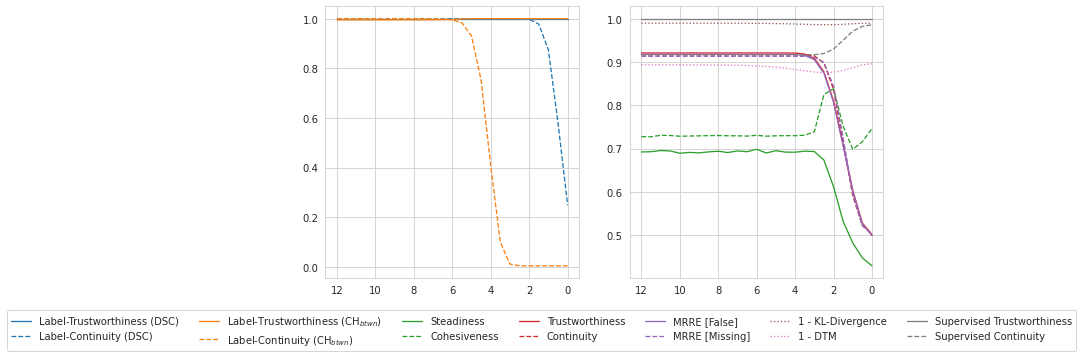

In [32]:

results_list_dict = read_results("overlapping_raw")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
lineplot_results(results_list_dict, "overlapping_raw", index_range=(0, 4), x_list = np.linspace(12, 0, 25), ax=axs[0], invert_x_axis=True)
lineplot_results(results_list_dict, "overlapping_raw", index_range=(4, 14), x_list = np.linspace(12, 0, 25), ax=axs[1], invert_x_axis=True)
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))




### Experiment E (2D UMAP and high dimensional as PCA projections with decreasing number of PC

#### Currently With fashion mnist dataset

In [7]:
## Dataset Generation (with digits data)
raw_orig, labels = np.load("./labeled-datasets/npy/fashion_mnist/data.npy"), np.load("./labeled-datasets/npy/fashion_mnist/label.npy")
emb = np.load("./labeled-datasets_embedding/fashion_mnist/umap.npy")

component_interval = 10
raws = []
raw_pca = PCA(n_components=300).fit_transform(raw_orig)
ex_var = PCA(n_components=300).fit(raw_orig).explained_variance_ratio_

explained_variances = []
for i in range(10):
	raw = raw_pca[:, i: i + component_interval]
	raws.append(raw)
	explained_variances.append(np.sum(ex_var[i: i + component_interval]))


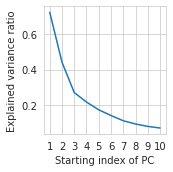

In [30]:
sns.set_style("whitegrid")

## set size
fig, ax = plt.subplots(figsize=(2.5, 2.5))

sns.lineplot(x=np.arange(1, component_interval + 1)[::-1], y=explained_variances[::-1])
## reverse x axis
# ax.invert_xaxis()
## set x axis label
ax.set_xlabel("Starting index of PC")
ax.set_ylabel("Explained variance ratio")
## set x ticks as integers
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig("./explained_variance/ex_exp_F.png", dpi=300)
plt.savefig("./explained_variance/ex_exp_F.pdf", dpi=300)


In [34]:
## compute the metrics of the original data and save
results_list_dict = compute_metrics(raws, emb, labels, 10, "pca_decreasing_digits")

100%|██████████| 10/10 [03:09<00:00, 18.97s/it]


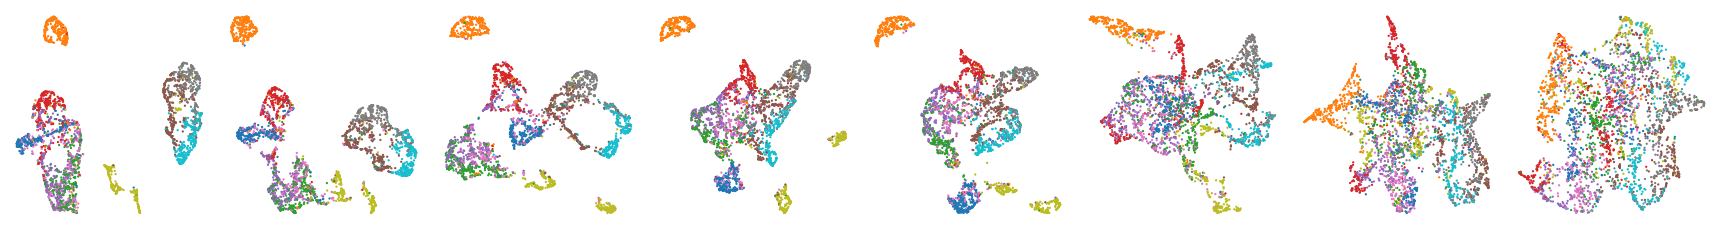

In [129]:
raws_umap = []
index_list = [0, 1, 2, 3, 4, 6, 8, 9]
for idx, i in enumerate(index_list):
	if idx == 0:
		raws_umap.append(umap.UMAP(random_state=0).fit_transform(raws[i]))
	else:
		raws_umap.append(umap.UMAP(random_state=0, init=raws_umap[idx-1]).fit_transform(raws[i]))

for i, raw_umap in enumerate(raws_umap):
	x_max, x_min = np.max(raw_umap[:, 0]), np.min(raw_umap[:, 0])
	y_max, y_min = np.max(raw_umap[:, 1]), np.min(raw_umap[:, 1])
	raw_umap[:, 0] = (raw_umap[:, 0] - x_min) / (x_max - x_min)
	raw_umap[:, 1] = (raw_umap[:, 1] - y_min) / (y_max - y_min)

visualize_results(raws_umap, labels, index=range(len(index_list)), s=1.5, path="./plot_embeddings/E", ylen=3.3)

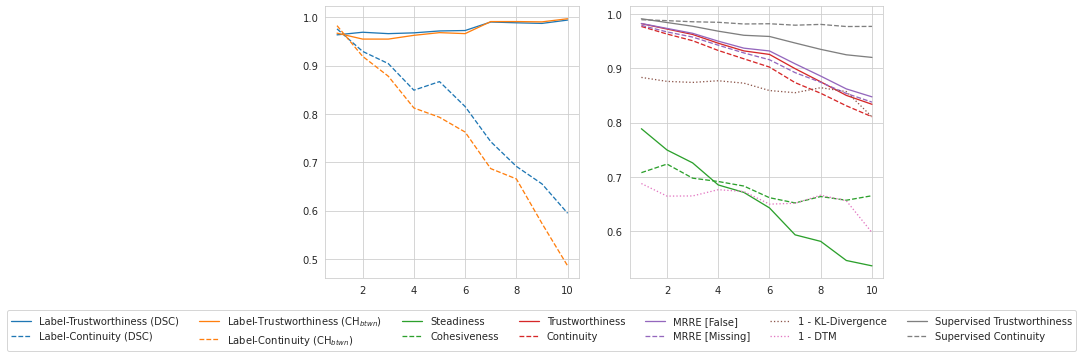

In [35]:


results_list_dict = read_results("pca_decreasing_digits")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
lineplot_results(results_list_dict, "pca_decreasing_digits", index_range=(0, 4), x_list = range(1, 11), ax=axs[0])
lineplot_results(results_list_dict, "pca_decreasing_digits", index_range=(4, 14), x_list = range(1, 11), ax=axs[1])
add_legend(ax=fig, bbox_to_anchor=(1.175, 0.05))



### Visualizing Results

In [58]:
## read
tests = ["randomizing_emb", "overlapping_circles", "overlapping_circles_more", "pca_expansion_digits", "mixing_raw", "overlapping_raw", "pca_decreasing_digits"]
x_lists = [np.linspace(0, 100, 25), np.linspace(60, 0, 25), np.linspace(4, 0, 25), range(1, 11), np.linspace(0, 100, 25), np.linspace(12, 0, 25), range(1,11), ]
y_labels = ["score", None, None, None, None, None, None]
x_labels = ["Replacement prob.","Angle btw two circles", "Dist. to the origin", "Number of PCs", "Replacement prob.", "Dist. to the origin", "Starting index of PC", ]
inverts = [False, True, True, True, False, True, False,]
x_tick_labels = [None, None, None, "int", None, None, "int"]


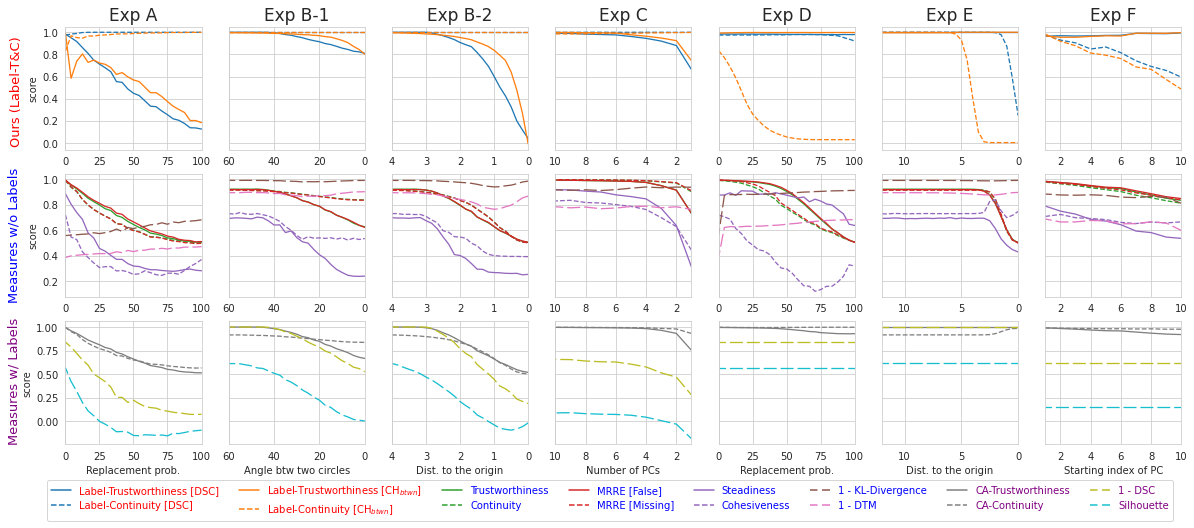

In [65]:
## plot for plots in the single figure
from matplotlib.lines import Line2D

fig, axs = plt.subplots(3, 7, figsize=(20, 10), sharey="row")

for i, test in enumerate(tests):
	results_list_dict = read_results(test)
	lineplot_results(results_list_dict, test,  index_range=(0, 4), x_list = x_lists[i], invert_x_axis=inverts[i], ax = axs[0, i], y_label=y_labels[i], x_label=None, xticklabels=x_tick_labels[i])
	lineplot_results(results_list_dict, test,  index_range=(4, 12), x_list = x_lists[i], invert_x_axis=inverts[i], ax = axs[1, i], y_label=y_labels[i], x_label=None, xticklabels=x_tick_labels[i])
	lineplot_results(results_list_dict, test,  index_range=(12, 16), x_list = x_lists[i], invert_x_axis=inverts[i], ax = axs[2, i], y_label=y_labels[i], x_label=x_labels[i], xticklabels=x_tick_labels[i])
	axs[0, i].margins(x=0)
	axs[1, i].margins(x=0)
	axs[2, i].margins(x=0)
## create legend based on dr_measures_name, linestyle, color...
legends_elements = []
for i, name in enumerate(dr_measures_name):
	## set text color red
	legends_elements.append(Line2D([0], [0], color=color_list[i], lw=1.5, label=name, linestyle=linestyle_list[i]))


## add legend
axs[2, 3].legend(handles=legends_elements, loc='upper center', bbox_to_anchor=(0.4, -0.25), ncol=8, fontsize=10)

for i, legend in enumerate(axs[2, 3].get_legend().get_texts()):
	if 0 <= i < 4:
		legend.set_color("red")
	elif 4 <= i < 12:
		legend.set_color("blue")
	elif 12 <= i < 16:
		legend.set_color("purple") 	

# axs[0, 0].set_title("Ours", rotation="vertical", x=-0.38, y=0.39, fontsize=13)
axs[0, 0].text(-0.41, 0.05, "Ours (Label-T&C)", rotation="vertical", fontsize=13, transform=axs[0, 0].transAxes,c="red")
axs[1, 0].set_title("Measures w/o Labels", rotation="vertical", x=-0.38, y=-0.07, fontsize=13, c="blue")
axs[2, 0].set_title("Measures w/ Labels", rotation="vertical", x=-0.38, y=-0.03, fontsize=13, c="purple")


axs[0, 0].set_title("Exp A", fontsize=17)
axs[0, 1].set_title("Exp B-1", fontsize=17)
axs[0, 2].set_title("Exp B-2", fontsize=17)
axs[0, 3].set_title("Exp C", fontsize=17)
axs[0, 4].set_title("Exp D", fontsize=17)
axs[0, 5].set_title("Exp E", fontsize=17)
axs[0, 6].set_title("Exp F", fontsize=17)

plt.subplots_adjust(bottom=0.3)
plt.savefig(f"./plot/summarize.png", dpi=300)
plt.savefig(f"./plot/summarize.pdf", dpi=300)


### For appendix: reproduction test for B-2

In [45]:
datasets = [
	"weather", "optical_recognition_of_handwritten_digits", 
	"mnist64", "har", "coil20",
	"olivetti_faces", "cnae9", 
	"student_grade", 
]
dataset_name = [
	"Weather", "Optical Recognition", "Mnist 64", "HAR", "Coil-20",
	"Olivetti Faces", "CNAE-9",
	"Student Grade", 
]

In [41]:
for dataset in datasets:
	raw, labels = np.load(f"./labeled-datasets/npy/{dataset}/data.npy"), np.load(f"./labeled-datasets/npy/{dataset}/label.npy")
	range_limit = 10
	emb_pca = PCA(n_components=range_limit + 5).fit_transform(raw)
	embs = []
	for i in range(range_limit):
		embs.append(emb_pca[:, :i+1]) 
	

	results_list_dict = compute_metrics(raw, embs, labels, range_limit, f"pca_expansion_{dataset}")


100%|██████████| 10/10 [02:36<00:00, 15.69s/it]


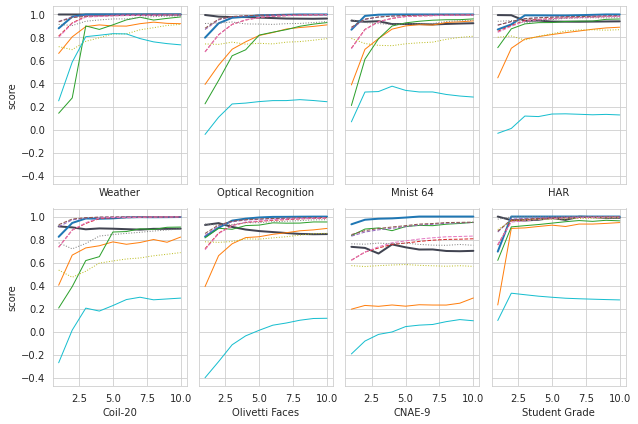

In [46]:
fig, axs = plt.subplots(2, 4, figsize=(9, 6), sharey=True, sharex=True)

for i, dataset in enumerate(datasets):
	results = read_results(f"pca_expansion_{dataset}")
	lineplot_results(
		results, dataset, 
		x_list = None, invert_x_axis=False,
		ax = axs[i // 4, i % 4],
		add_legend = False,
		y_label = "score" if i % 4 == 0 else None,
		x_label = dataset_name[i]
	)


plt.tight_layout()
plt.savefig("./plot/b2_reproduce.png", dpi=300)
plt.savefig("./plot/b2_reproduce.pdf", dpi=300)

### For appendix: reproduction test for C-2

In [43]:
### For appendix: reproduction test for B-2
for dataset in datasets:
	raw_orig, labels = np.load(f"./labeled-datasets/npy/{dataset}/data.npy"), np.load(f"./labeled-datasets/npy/{dataset}/label.npy")
	emb = np.load(f"./labeled-datasets_embedding/{dataset}/umap.npy")
	component_interval = 10
	range_limit = 10
	raws = []
	raw_pca = PCA(n_components=22).fit_transform(raw_orig)
	for i in range(range_limit):
		raws.append(raw_pca[:, i: i + component_interval])
	

	results_list_dict = compute_metrics(raws, emb, labels, range_limit, f"pca_decreasing_{dataset}")




100%|██████████| 10/10 [01:39<00:00,  9.95s/it]


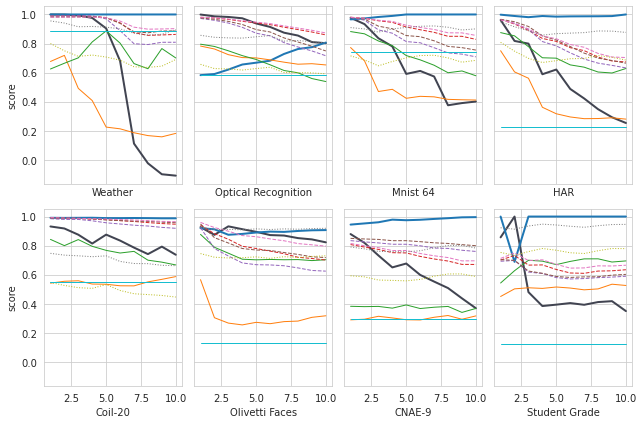

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(9, 6), sharey=True, sharex=True)

for i, dataset in enumerate(datasets):
	results = read_results(f"pca_decreasing_{dataset}")
	lineplot_results(
		results, dataset, 
		x_list = None, invert_x_axis=False,
		ax = axs[i // 4, i % 4],
		add_legend = False,
		y_label = "score" if i % 4 == 0 else None,
		x_label = dataset_name[i]
	)


plt.tight_layout()
plt.savefig("./plot/c2_reproduce.png", dpi=300)
plt.savefig("./plot/c2_reproduce.pdf", dpi=300)